In [2]:
# From the raccoon tutorial
#https://github.com/datitran/raccoon_dataset/blob/master/xml_to_csv.py

import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    
    return xml_df

In [13]:
df = xml_to_csv(source)

In [34]:
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,201503.20150602.121659332.69206.orig.jpg,1360,1024,Substrate A,89,114,102,120
1,201503.20150602.121659332.69206.orig.jpg,1360,1024,Small shell hash,77,141,95,152
2,201503.20150602.121659332.69206.orig.jpg,1360,1024,sand dollar,492,335,521,365
3,201503.20150602.121659332.69206.orig.jpg,1360,1024,sand dollar,679,33,708,63
4,201503.20150602.121659332.69206.orig.jpg,1360,1024,sand dollar,451,333,480,363


In [15]:
df.columns

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')

sand dollar         3648
Substrate A           26
Small shell hash      11
Hermit crab            3
Substrate B            3
Scallop                2
Moon Snail             1
Whelk                  1
Name: class, dtype: int64


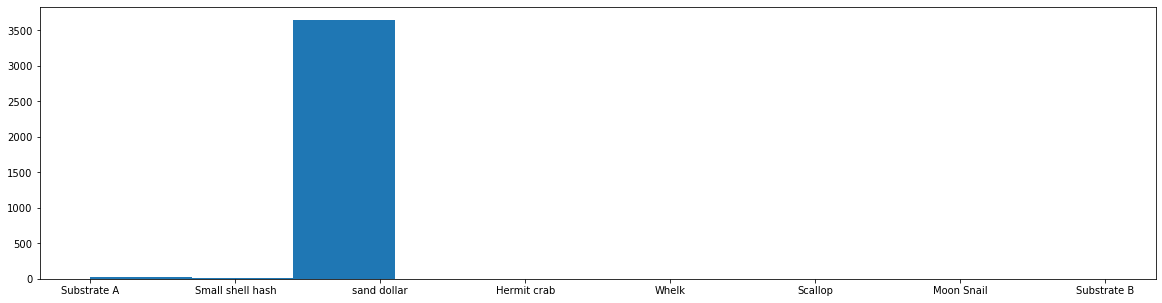

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 5))
plt.hist(df['class'], align = 'mid');

print(df['class'].value_counts())

In [83]:
import numpy as np

source = 'sample_data/'

# Can edit for other purposes
def sample_xml(source):
    xml = []
    image = []
    
    for file in os.listdir(source):
        if('xml' in file):
            xml.append(source + file)
        if('jpg' in file):
            image.append(source + file)
    
    index = np.random.randint(len(xml))
    
    return xml[index], image[index]
    
xml, img = sample_xml(source)

print(xml,'\n', img)

sample_data/201503.20150602.121602428.68866.orig.xml 
 sample_data/201503.20150602.121551560.68801.orig.jpg
